In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import cv2 # pip install name: opencv-python
import subprocess
from pathlib import Path
import glob
import math
import pandas as pd

# loading images

Using modified functions from the eSYMb-drawing-to-vectors repository to load images:

In [2]:
Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())

PosixPath('/Users/christianstenbro/Programming/disk_ddm')

In [3]:
# create image file path list
def list_files():

    # getting local root of GitHub repository
    repo_root = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())

    # specify stimuli folder
    stim_folder = repo_root / 'disk_stimuli' / 'stimuli'

    # we can now assemble the path
    file_path = str(stim_folder / '*')

    # and use glob to construct a list of all paths
    path_list = glob.glob(file_path)

    return path_list

First, a test to see that images are loaded and binarized correctly:

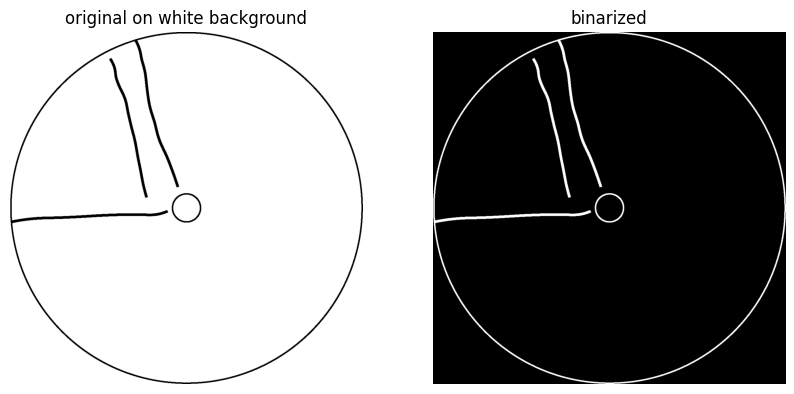

In [4]:
# loading an plotting a single file
path_list = list_files()
test_img = cv2.imread(path_list[1], cv2.IMREAD_UNCHANGED)

# merging non-transparent (!= alpha) channels
b, g, r, a = cv2.split(test_img)
gray = cv2.cvtColor(cv2.merge([b, g, r]), cv2.COLOR_BGR2GRAY)

# sets transparent background to white
gray[a == 0] = 255 

# inverts the image to create white on black
img_bin = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY_INV)[1]

# plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(gray, cmap='gray')
ax[0].set_title('original on white background')
ax[0].axis('off')

ax[1].imshow(img_bin, cmap='gray')
ax[1].set_title('binarized')
ax[1].axis('off')

plt.show()

Now we can load all images:

In [5]:
# load images from the path list. This function works with black-line pngs with transparent backgrounds.
def load_images():

    # set up empty image lists
    img_original_list = []
    img_bin_list = []
                
    # load image file names
    path_list = list_files()

    # load and binarize images
    for i in range(len(path_list)):

        img = cv2.imread(path_list[i], cv2.IMREAD_UNCHANGED)

        b, g, r, a = cv2.split(img)
        gray = cv2.cvtColor(cv2.merge([b, g, r]), cv2.COLOR_BGR2GRAY)
        gray[a == 0] = 255
        img_bin = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY_INV)[1]

        # append to lists
        img_original_list.append(gray)
        img_bin_list.append(img_bin)

    return img_original_list, img_bin_list

In [6]:
# loading image files into the notebook
img_original_list, img_bin_list = load_images()

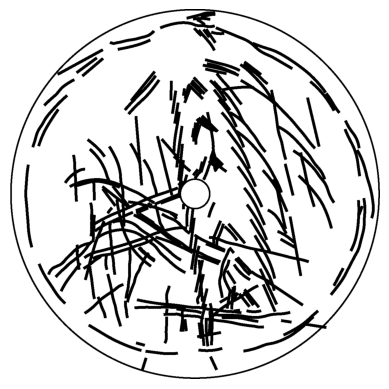

In [7]:
# let's display an image
plt.imshow(img_original_list[5], cmap='gray')
plt.axis('off')
plt.show()

In [23]:
# checking out the raw data structure:
img_bin_list[1]
values, counts = np.unique(img_bin_list[1], return_counts=True)
print(values, counts)

# extracting image dimensions
img_bin_list[1].shape

[0 1] [1372688   35094]


(1186, 1187)

Save the images to a new folder, and create a list of only filenames for later use:

In [ ]:
filename_list = []

for i in range(len(path_list)):

    # get original names - indices will match the files of the img_lists
    path_list = list_files()

    # extract file name for img[i]
    filename = path_list[i]
    repo_root = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())
    prefix = repo_root / 'disk_stimuli' / 'stimuli'
    filename = Path(filename).relative_to(prefix)

    # add to new list
    filename_list.append(str(filename))

    # we now need to create a path for the new files
    binary_path = repo_root / 'disk_stimuli' / 'binarized'
    destination_name = str(repo_root / binary_path / filename)

    # writing img[i] to specified folder - note that image is scaled from [0,1] --> [0,255] where 255 = white.
    cv2.imwrite(filename=destination_name, img = img_bin_list[i]*255)

    # saving JPEG copy for computing features in Mathematica (could use PNGs after all...)
    filename = str(filename)
    filename_jpeg = filename.replace('.png', '.jpg')
    jpeg_path = repo_root / 'disk_stimuli' / 'binarized_jpeg'
    jpeg_destination_name = str(repo_root / jpeg_path / filename_jpeg)
    cv2.imwrite(jpeg_destination_name, img_bin_list[i]*255, [cv2.IMWRITE_JPEG_QUALITY, 100])

In [10]:
print('done')

done


# Computing shannon entropy for binarized images

Following the scikit-image documentation: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.shannon_entropy

In [ ]:
# looping through images and computing shannon entropy
entropy_list = []

for i in range(len(img_bin_list)):
    entropy_list.append(skimage.measure.shannon_entropy(img_bin_list[i]))

In [156]:
# creating plot with all binarized disks and their shannon entropy

# calculate grid dimenions
n_images = len(img_bin_list)
n_cols = 6
n_rows = math.ceil(n_images / n_cols)

# create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2 * n_rows))
axes = axes.flatten() 

# plot each image
for i in range(len(img_bin_list)):
    axes[i].imshow(img_bin_list[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'H = {entropy_list[i]:.3f}') # rounded to 3 digits

# hide extra subplots
for i in range(len(img_bin_list), len(axes)):
    axes[i].axis('off')

# global title
fig.suptitle('Shannon Entropy for Binarized Disks', fontsize=16)
plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.96]) 
#plt.show()

# saving the plot
plt.savefig('all_disks_entropy_plot.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
# creating a small data frame to store filenames + shannon entropy
entropy_df = pd.DataFrame({'image': filename_list,
                          'entropy': entropy_list})

In [164]:
# saving the dataframe
entropy_df.to_csv('../data/entropy_df.csv', index=False)